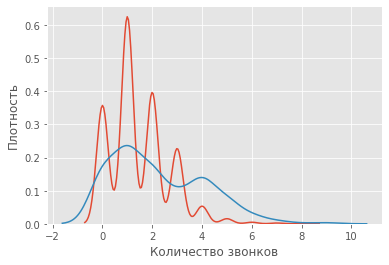

In [14]:
import pandas as pd #  pandas для работы с таблицами
from matplotlib import pyplot as plt # графики
plt.style.use('ggplot')# стиль графиков
plt.rcParams['figure.figsize'] = 10, 6 # размер окна графиков
import seaborn as sns # для графиков
%matplotlib inline 
URL='https://drive.google.com/uc?id=1U9LC5ECI2_Jvq4FrZNCOn3gCT7T5Y5DD'
telecom_data = pd.read_csv(URL) # загружаем данные в таблицу

# выбираем и отображаем звонки (столбец 'Customer service calls') лояльных клиентов (столбец ['Churn'] == False))
fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == False]['Customer service calls'], label = 'Loyal')
# выбираем и отображаем звонки (столбец 'Customer service calls') нелояльных, бывших клиентов (столбец ['Churn'] == True))
fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == True]['Customer service calls'], label = 'Churn')        

fig.set(xlabel='Количество звонков', ylabel='Плотность') # подписи осей  
plt.show() # отображаем

Tree         : 0.0249 (error) = 0.0003 (bias^2)  + 0.0146 (var) + 0.0098 (noise)
Bagging(Tree): 0.0195 (error) = 0.0005 (bias^2)  + 0.0090 (var) + 0.0098 (noise)


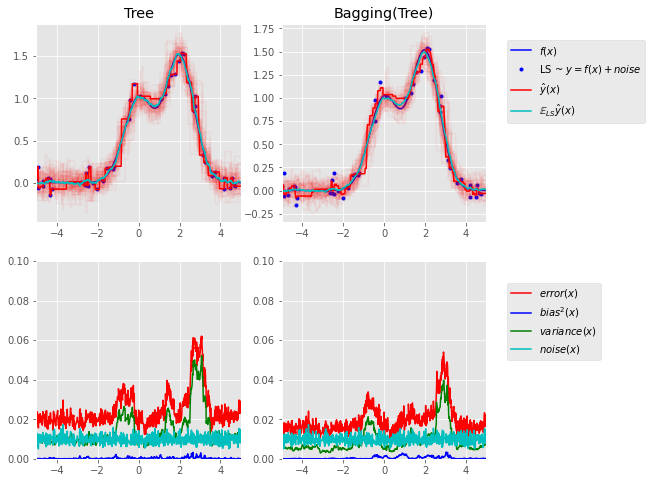

In [15]:
import numpy as np #
import matplotlib.pyplot as plt # 

from sklearn.ensemble import BaggingRegressor # беггинг
from sklearn.tree import DecisionTreeRegressor # дерево для регрессии

# Установки
n_repeat = 50       # Число итераций для генерации шума
n_train = 50        # число примеров обучения
n_test = 1000       # число примеров теста
noise = 0.1         # дисперсия (стандартное отклонение) шума
np.random.seed(13) # начало генератора случайных чисел 

# проверяемые модели, дерево и ансамбль деревьев
# по умолчанию в ансамбле будет 10 деревьев.
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)",
               BaggingRegressor(DecisionTreeRegressor(),
                                n_estimators=10,max_samples=1.0))]

# число проверяемых моделей
n_estimators = len(estimators)

# Функция для генерации данных
def f(x):
    x = x.ravel() #
    # пример красивой функции
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

# функция для генерации и добавления шума в данные
def generate(n_samples, noise, n_repeat=1):
    # n_samples - число примеров,
    # noise - дисперсия шума
    # n_repeat - число повторов
    
    # входы в функцию - абциссы по оси OX, случайно выбранные
    X = np.random.rand(n_samples) * 10 - 5 # некоторые случайные числа от -5 до 5
    X = np.sort(X) # отсортированы
    
    # Выходы функции
    if n_repeat == 1: # если повтор один
        # добавляем шум - случайные числа с нормальным распределением, с нулевым средним, с заданной дисперсией noise 
        y = f(X) + np.random.normal(0.0, noise, n_samples) #
    else:
        y = np.zeros((n_samples, n_repeat)) # иначе сначала забиваем нулями

        for i in range(n_repeat): # а потом в цикле по количеству повторов
            # делаем несколько зашумленных функций
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1)) # отформатируем входы в этом виде

    return X, y # возвратим входы и выходы функции с шумом


X_train = [] # место под обучающие входы
y_train = [] # место под обучающие выходы

for i in range(n_repeat): # в цикле по количеству повторов
    X, y = generate(n_samples=n_train, noise=noise) # генерируем данные с шумом
    X_train.append(X) # добавляем их ко входам
    y_train.append(y) # и выходам
# то же для теста 
X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8)) # полотно для рисования

# В цикле по количеству моделей
for n, (name, estimator) in enumerate(estimators): #
    # вычисляем выходы
    y_predict = np.zeros((n_test, n_repeat)) # место под выходы
    #
    for i in range(n_repeat): # в цикле по количеству повторов
        estimator.fit(X_train[i], y_train[i]) # обучаем модель на своих данных
        y_predict[:, i] = estimator.predict(X_test) # считаем выход модели

    # Bias^2 + Variance + Noise вычисляем составляющие ошибки
    y_error = np.zeros(n_test) # место под результаты теста
    
    # средняя ошибка
    for i in range(n_repeat): # в цикле по количеству повторов
        for j in range(n_repeat): # еще раз в цикле по количеству повторов
            # находим сумму квадратов разности истинного и расчитанного выхода для всех комбинаций
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2
    
    y_error /= (n_repeat * n_repeat) # делим на количество комбинаций - получаем среднее

    y_noise = np.var(y_test, axis=1) # часть ошибки от шума (дисперсия).
    # Примечание: т.к. дисперсия считается для отклонения от среднего значения, то нам не надо самим искать это среднее
    # axis=1 показывает что мы ищем по дисперсию по повторам, а не по примерам.
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2 # часть ошибки от смещения - квадрат отклонения среднего от истинного значений
    y_var = np.var(y_predict, axis=1) # часть ошибки от дисперсии результатов
    # выводим эти числа на экран
    print("{0:13.15}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Рисуем картинки
    plt.subplot(2, n_estimators, n + 1) # свои подграфики каждой модели
    plt.plot(X_test, f(X_test), "b", label="$f(x)$") # истинная функция
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$") # обучающие точки
    # 
    for i in range(n_repeat): # в цикле по количеству повторов
        if i == 0: # если это первый повтор рисуем результаты
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$") 
        else: # другие повторы рисуем полупрозрачным цветом
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)
    
    # рисуем среднее значение 
    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5]) # область просмотра графика
    plt.title(name) # название графика
    
    # легенда графика на последней итерации
    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5)) #
    # на других подграфиках рисуем:
    plt.subplot(2, n_estimators, n_estimators + n + 1) #
    plt.plot(X_test, y_error, "r", label="$error(x)$") # ошибку модели
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"), # квадрат смещения ошибки модели
    plt.plot(X_test, y_var, "g", label="$variance(x)$"), # дисперсию ошибки модели
    plt.plot(X_test, y_noise, "c", label="$noise(x)$") # дисперсию шума модели
    #
    plt.xlim([-5, 5]) #  область просмотра графика по Х
    plt.ylim([0, 0.1]) # область просмотра графика по У

    if n == n_estimators - 1: # легенда
        plt.legend(loc=(1.1, .5)) #

plt.subplots_adjust(right=.75) # немного сожмем графики настроив правую границу их, чтобы лучше смотрелось
plt.show() # отображаем графики

In [16]:
# Классификация с шумом  

# функция для рисования разделяющей поверхности на плоскости

# Div_plate(clf,flip_level) принимает объект-классификатор и уровень шума (ошибок)
# создает двумерные данные, обучает классификатор, рисует разделяющую поверхность 
  
def Div_plate(clf, flip_level):
    from sklearn.datasets import make_classification # для генерации данных
    from sklearn.model_selection import train_test_split # для разделения на обучение и тест
    import numpy as np
    import seaborn as sns # для простого отображения
    import matplotlib.pyplot as plt #
    # создаем данные
    X,y = make_classification(n_samples=10000, # число примеров
                              n_features=2, # число признаков (атрибутов)
                              n_informative=2, # из них информативных
                              n_redundant=0, # из них не информативных
                              n_repeated=0, # из них повторяющихся
                              n_classes=2, # число классов
                              n_clusters_per_class=1, # число кластеров на класс
                              class_sep=2, # влияет на расстояние между кластерами
                              flip_y=flip_level, # доля ошибок (шума)
                              weights=[0.5,0.5], # пропорции числа данных в классах
                              random_state=17) # 

    # разделяем на обучающие и тестовые, случайно
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
    # рисуем данные
    plt.subplots();#
    ax1=plt.gca();#
    sns.scatterplot(X_train[:,0],X_train[:,1],hue=y_train,ax=ax1);# обучающие
    sns.scatterplot(X_test[:,0],X_test[:,1],hue=y_test,ax=ax1,marker="+");# тестовые
    ax1.set_title("Data With Noise");#
    plt.show();#
    # Создаем классификатор на основе ансамбля. Изменяйте параметры и смотрите как это влияет на обучение
    clf.fit(X_train, y_train) # обучаем 
    y_pred = clf.predict(X_test) # проверяем на тесттовых данных
    score=clf.score(X_test, y_test) # считаем среднюю точность
    print('Score=',score)
    ind=y_test==y_pred; # индексы совпадений результата классификации и меток классов
    plt.subplots(); 
    ax2=plt.gca();
    # рисуем "правильно" распознанные примеры
    sns.scatterplot(X_test[ind,0],X_test[ind,1],hue=y_test[ind],ax=ax2);
    # рисуем "неправильно" распознанные примеры
    sns.scatterplot(X_test[~ind,0],X_test[~ind,1],hue=y_pred[~ind],ax=ax2,marker="+");
    #sns.scatterplot(X_test[:,0],X_test[:,1],hue=y_test[:],ax=ax2,marker="+");
    ax2.set_title("With Noise");
    # считаем и рисуем разделяющую поверхность.
    plot_step=0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # немного измененные минимальное и максимальые значения превого атрибута 
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # немного измененные минимальное и максимальые значения второго атрибута 
    # считаем прямоугольную сетку возможных значений этих атрибутов
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), #
                         np.arange(y_min, y_max, plot_step)) #
    # считаем выход классификатора для всех примеров сетки
    # не забыв что массивы данных нужно привести к требуемому размеру.
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape) # и преобразуем обратно в исходному размеру
    # рисуем разделяющую поверхность
    cs = plt.contourf(xx, yy, Z, levels=1, colors=['blue','orange'],alpha=0.3) # рисуем контурную карту
    plt.show();

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


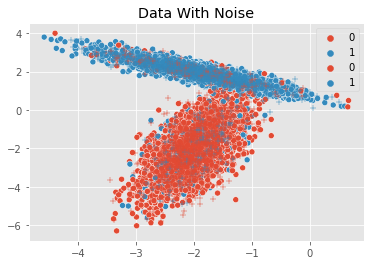

Score= 0.88


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


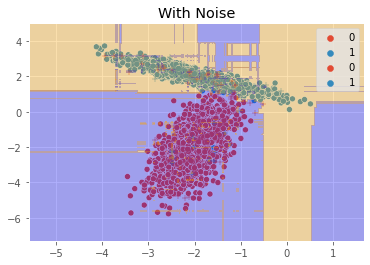

In [18]:
from sklearn.ensemble import   BaggingClassifier #
from sklearn.tree import DecisionTreeClassifier # дерево для регрессии
clf=BaggingClassifier(DecisionTreeClassifier(), n_estimators=10,max_samples=0.5)
flip_level=0.2
Div_plate(clf,flip_level)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


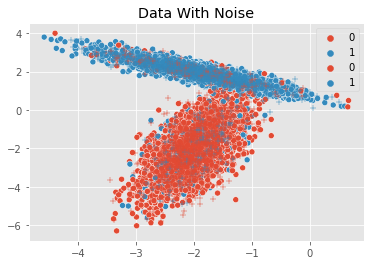

Score= 0.8790909090909091


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


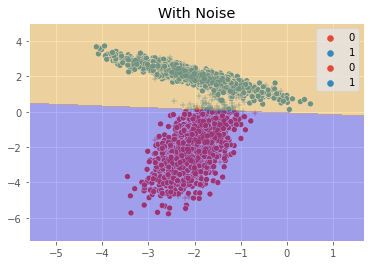

In [19]:
from sklearn.ensemble import   BaggingClassifier #
from sklearn.linear_model import LogisticRegression # модель для регрессии
#from sklearn.linear_model import LinearRegression # модель для регрессии
clf=BaggingClassifier(LogisticRegression(), n_estimators=10,max_samples=0.5, max_features=0.5)
#clf=BaggingClassifier(LinearRegression(), n_estimators=10,max_samples=0.5, max_features=0.5)
flip_level=0.2
Div_plate(clf,flip_level)